# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [2]:
from joblib import Parallel, delayed
from joblib import parallel_backend

In [3]:
df = pd.read_csv("data_resampled_40.csv")

### 4.1.3 Cross Vallidation

In [4]:
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Define the number of samples to select
n_samples = 50

# Perform random sampling
sampled_majority = majority_class.sample(n_samples, random_state=123)
sampled_minority = minority_class.sample(n_samples, random_state=123)

# Combine sampled data
sampled_df = pd.concat([sampled_majority, sampled_minority])
sampled_df

#test
y_test = sampled_df['Outcome']
x_test = sampled_df.drop(columns='Outcome')

# train
# Separate remaining data for training
remaining_df = df.drop(sampled_df.index)
y_train = remaining_df['Outcome']
x_train= remaining_df.drop(columns='Outcome')

scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [5]:
#from sklearn.model_selection import RepeatedKFold
rs=123
cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=345)

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [6]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [7]:
# Creating and running our optimization
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=100)

[I 2024-08-26 01:24:15,373] A new study created in memory with name: KNN
[I 2024-08-26 01:24:15,834] Trial 0 finished with value: 0.6576553613522802 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'metric': 'minkowski', 'p': 50, 'algorithm': 'brute', 'leaf_size': 73}. Best is trial 0 with value: 0.6576553613522802.
[I 2024-08-26 01:24:15,976] Trial 1 finished with value: 0.7998537475936461 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 62}. Best is trial 1 with value: 0.7998537475936461.
[I 2024-08-26 01:24:16,133] Trial 2 finished with value: 0.73138398338505 and parameters: {'n_neighbors': 76, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 9}. Best is trial 1 with value: 0.7998537475936461.
[I 2024-08-26 01:24:16,448] Trial 3 finished with value: 0.7520198584794635 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'euclidean', 'p': 

[I 2024-08-26 01:24:22,417] Trial 32 finished with value: 0.8182776237643455 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 46}. Best is trial 11 with value: 0.8206188117519991.
[I 2024-08-26 01:24:22,536] Trial 33 finished with value: 0.8206188117519991 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 69}. Best is trial 11 with value: 0.8206188117519991.
[I 2024-08-26 01:24:22,664] Trial 34 finished with value: 0.8187007497901372 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 11 with value: 0.8206188117519991.
[I 2024-08-26 01:24:22,810] Trial 35 finished with value: 0.8165182881357589 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 11 

[I 2024-08-26 01:24:27,839] Trial 64 finished with value: 0.8239093323540423 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'kd_tree', 'leaf_size': 49}. Best is trial 56 with value: 0.8239093323540423.
[I 2024-08-26 01:24:27,968] Trial 65 finished with value: 0.8185245082468043 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 51}. Best is trial 56 with value: 0.8239093323540423.
[I 2024-08-26 01:24:28,089] Trial 66 finished with value: 0.8239093323540423 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'auto', 'leaf_size': 56}. Best is trial 56 with value: 0.8239093323540423.
[I 2024-08-26 01:24:28,209] Trial 67 finished with value: 0.8239093323540423 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'auto', 'leaf_size': 56}. Best is trial 56 with va

[I 2024-08-26 01:24:32,588] Trial 97 finished with value: 0.7702762441388 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'auto', 'leaf_size': 40}. Best is trial 56 with value: 0.8239093323540423.
[I 2024-08-26 01:24:32,714] Trial 98 finished with value: 0.8206188117519991 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'auto', 'leaf_size': 68}. Best is trial 56 with value: 0.8239093323540423.
[I 2024-08-26 01:24:32,895] Trial 99 finished with value: 0.7514811664611147 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'ball_tree', 'leaf_size': 71}. Best is trial 56 with value: 0.8239093323540423.


In [8]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 56
Best accuracy: 0.8239093323540423
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'kd_tree', 'leaf_size': 50}


              precision    recall  f1-score   support

           0     0.7031    0.9000    0.7895        50
           1     0.8611    0.6200    0.7209        50

    accuracy                         0.7600       100
   macro avg     0.7821    0.7600    0.7552       100
weighted avg     0.7821    0.7600    0.7552       100



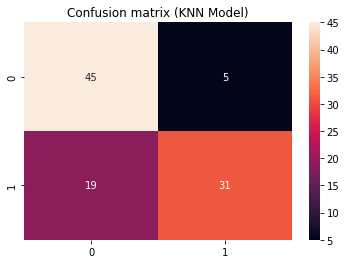

In [36]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred, digits=4))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

Accuracy: 0.7600
Precision: 0.8611
Recall: 0.6200
F1 Score: 0.7209

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        50
           1       0.86      0.62      0.72        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



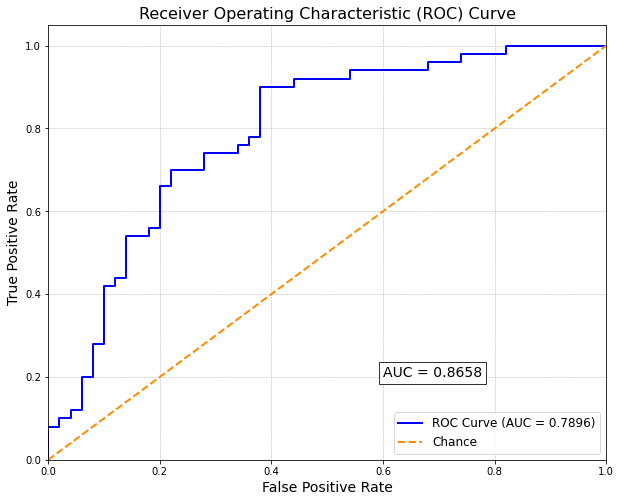

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.3 Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [39]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=100)

[I 2024-08-26 17:58:42,859] A new study created in memory with name: logr
[I 2024-08-26 17:58:43,125] Trial 0 finished with value: 0.710482102552494 and parameters: {'C': 0.03799253626179679, 'solver': 'liblinear', 'max_iter': 126}. Best is trial 0 with value: 0.710482102552494.
[I 2024-08-26 17:58:44,582] Trial 1 finished with value: 0.7709635301611095 and parameters: {'C': 6.464241274259362, 'solver': 'lbfgs', 'max_iter': 837}. Best is trial 1 with value: 0.7709635301611095.
[I 2024-08-26 17:58:44,805] Trial 2 finished with value: 0.7527517346453138 and parameters: {'C': 0.1803480905226795, 'solver': 'liblinear', 'max_iter': 921}. Best is trial 1 with value: 0.7709635301611095.
[I 2024-08-26 17:58:46,221] Trial 3 finished with value: 0.7715692693165809 and parameters: {'C': 2.654416749571367, 'solver': 'lbfgs', 'max_iter': 582}. Best is trial 3 with value: 0.7715692693165809.
[I 2024-08-26 17:58:46,666] Trial 4 finished with value: 0.6809106211453002 and parameters: {'C': 4.406228244

[I 2024-08-26 17:59:33,988] Trial 40 finished with value: 0.6804799899820391 and parameters: {'C': 0.007152688434911958, 'solver': 'saga', 'max_iter': 140}. Best is trial 20 with value: 0.7747763963774397.
[I 2024-08-26 17:59:35,257] Trial 41 finished with value: 0.7745970016830274 and parameters: {'C': 0.001044928227435955, 'solver': 'lbfgs', 'max_iter': 232}. Best is trial 20 with value: 0.7747763963774397.
[I 2024-08-26 17:59:36,723] Trial 42 finished with value: 0.774071926381315 and parameters: {'C': 0.003014651856913329, 'solver': 'lbfgs', 'max_iter': 291}. Best is trial 20 with value: 0.7747763963774397.
[I 2024-08-26 17:59:38,460] Trial 43 finished with value: 0.7741742822012444 and parameters: {'C': 0.0016327157892866411, 'solver': 'lbfgs', 'max_iter': 252}. Best is trial 20 with value: 0.7747763963774397.
[I 2024-08-26 17:59:39,581] Trial 44 finished with value: 0.7509453589330829 and parameters: {'C': 0.0024209297698976587, 'solver': 'lbfgs', 'max_iter': 91}. Best is trial 2

[I 2024-08-26 18:00:26,142] Trial 80 finished with value: 0.7741809640907114 and parameters: {'C': 0.0017674083960864191, 'solver': 'newton-cg', 'max_iter': 926}. Best is trial 54 with value: 0.7751625371556412.
[I 2024-08-26 18:00:27,554] Trial 81 finished with value: 0.7747763963774397 and parameters: {'C': 0.0012468106141750757, 'solver': 'lbfgs', 'max_iter': 218}. Best is trial 54 with value: 0.7751625371556412.
[I 2024-08-26 18:00:28,972] Trial 82 finished with value: 0.7744446834398372 and parameters: {'C': 0.0019169257661119977, 'solver': 'lbfgs', 'max_iter': 999}. Best is trial 54 with value: 0.7751625371556412.
[I 2024-08-26 18:00:30,394] Trial 83 finished with value: 0.7747763963774397 and parameters: {'C': 0.0012254929047718593, 'solver': 'lbfgs', 'max_iter': 874}. Best is trial 54 with value: 0.7751625371556412.
[I 2024-08-26 18:00:31,446] Trial 84 finished with value: 0.7745380936546178 and parameters: {'C': 0.0025840340503481525, 'solver': 'lbfgs', 'max_iter': 880}. Best 

In [40]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 54
Best accuracy: 0.7751625371556412
Best hyperparameters: {'C': 0.0013539695141414313, 'solver': 'lbfgs', 'max_iter': 927}


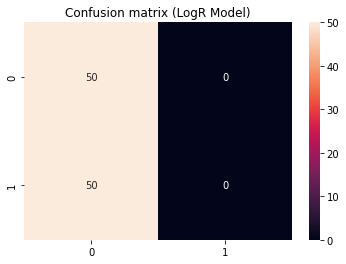

              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667        50
           1     0.0000    0.0000    0.0000        50

    accuracy                         0.5000       100
   macro avg     0.2500    0.5000    0.3333       100
weighted avg     0.2500    0.5000    0.3333       100



(0.5, 0.5, 0.5, None)

In [41]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")

Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100



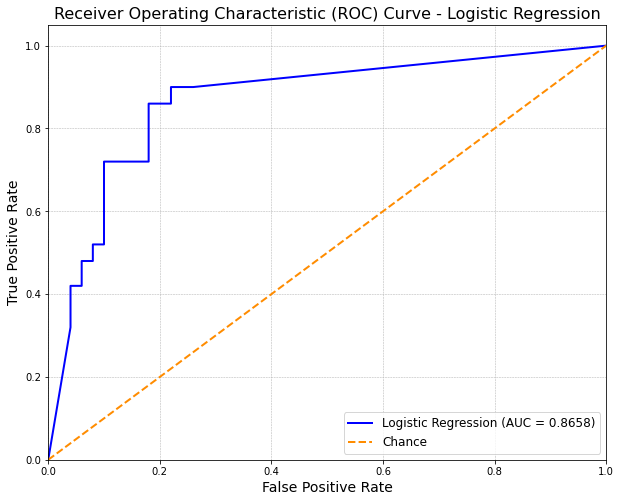

In [54]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.4 Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [17]:
# Creating and running our optimization

study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=100)

[I 2024-08-26 01:28:47,133] A new study created in memory with name: Dect
[I 2024-08-26 01:28:47,264] Trial 0 finished with value: 0.8128450274102162 and parameters: {'max_depth': 55, 'ccp_alpha': 0.08917176761024391, 'max_features': 'auto', 'min_samples_split': 29, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8128450274102162.
[I 2024-08-26 01:28:47,388] Trial 1 finished with value: 0.8163915691549355 and parameters: {'max_depth': 43, 'ccp_alpha': 0.0010747945423079238, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.8163915691549355.
[I 2024-08-26 01:28:47,514] Trial 2 finished with value: 0.8128450274102162 and parameters: {'max_depth': 38, 'ccp_alpha': 0.028955142040895054, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 1 with value: 0.8163915691549355.
[I 2024-08-26 01:28:47,639] Trial 3 finished with value: 0.81

[I 2024-08-26 01:28:51,194] Trial 29 finished with value: 0.8128450274102162 and parameters: {'max_depth': 53, 'ccp_alpha': 0.12538839790781542, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 25 with value: 0.8330071637222969.
[I 2024-08-26 01:28:51,333] Trial 30 finished with value: 0.8128450274102162 and parameters: {'max_depth': 49, 'ccp_alpha': 0.12580995840542836, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 25 with value: 0.8330071637222969.
[I 2024-08-26 01:28:51,473] Trial 31 finished with value: 0.8293993766755744 and parameters: {'max_depth': 58, 'ccp_alpha': 0.01595565156905271, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 25 with value: 0.8330071637222969.
[I 2024-08-26 01:28:51,615] Trial 32 finished with value: 0.8219845308088355 and parameters: {'max_depth': 56, 'ccp_alpha': 0.002361

[I 2024-08-26 01:28:55,281] Trial 58 finished with value: 0.8219845308088355 and parameters: {'max_depth': 34, 'ccp_alpha': 0.0014481152655853393, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 25 with value: 0.8330071637222969.
[I 2024-08-26 01:28:55,424] Trial 59 finished with value: 0.7938302837557225 and parameters: {'max_depth': 46, 'ccp_alpha': 0.003130864209992132, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 25 with value: 0.8330071637222969.
[I 2024-08-26 01:28:55,564] Trial 60 finished with value: 0.8142816032397567 and parameters: {'max_depth': 43, 'ccp_alpha': 0.0010099962362064444, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 25 with value: 0.8330071637222969.
[I 2024-08-26 01:28:55,703] Trial 61 finished with value: 0.8316553168062762 and parameters: {'max_depth': 37, 'ccp_alpha'

[I 2024-08-26 01:28:59,510] Trial 87 finished with value: 0.8316553168062762 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0016188882733080452, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 76 with value: 0.8373064834875283.
[I 2024-08-26 01:28:59,650] Trial 88 finished with value: 0.2733157570453227 and parameters: {'max_depth': 48, 'ccp_alpha': 2.6038173657610497, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 76 with value: 0.8373064834875283.
[I 2024-08-26 01:28:59,789] Trial 89 finished with value: 0.810806320125075 and parameters: {'max_depth': 40, 'ccp_alpha': 0.0041966128548995745, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 76 with value: 0.8373064834875283.
[I 2024-08-26 01:28:59,930] Trial 90 finished with value: 0.8076397660439408 and parameters: {'max_depth': 37, 'ccp_alpha': 0.0

In [18]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 76
Best accuracy: 0.8373064834875283
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.002820998072979784, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'entropy'}


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



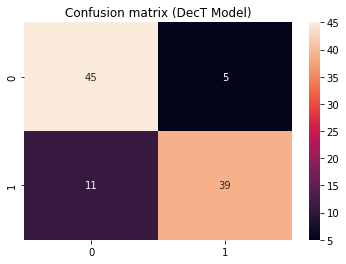

In [19]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

Accuracy: 0.7600
Precision: 0.8611
Recall: 0.6200
F1 Score: 0.7209

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        50
           1       0.86      0.62      0.72        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



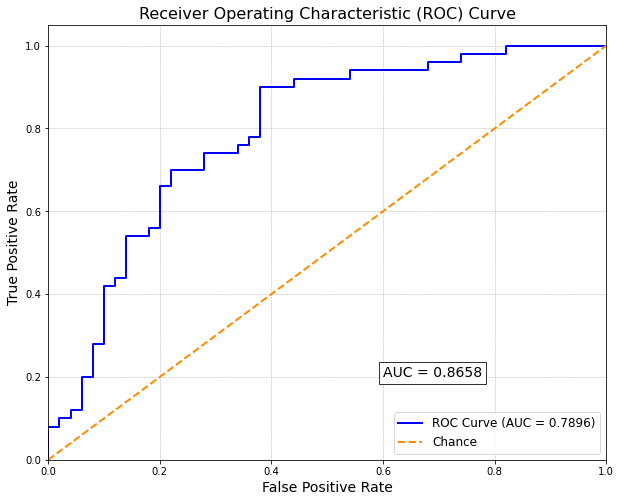

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.5 SVM (Support Vector Machine)

In [21]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [22]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=100)

[I 2024-08-26 01:29:01,394] A new study created in memory with name: SVM
[I 2024-08-26 01:29:02,283] Trial 0 finished with value: 0.8156828024242964 and parameters: {'C': 0.25882470980892014, 'gamma': 0.09299941055561108}. Best is trial 0 with value: 0.8156828024242964.
[I 2024-08-26 01:29:03,105] Trial 1 finished with value: 0.8224306617432093 and parameters: {'C': 2.335326463920571, 'gamma': 0.04254422416201712}. Best is trial 1 with value: 0.8224306617432093.
[I 2024-08-26 01:29:04,675] Trial 2 finished with value: 0.2733157570453227 and parameters: {'C': 0.0010916262404196719, 'gamma': 0.49896643223215315}. Best is trial 1 with value: 0.8224306617432093.
[I 2024-08-26 01:29:05,448] Trial 3 finished with value: 0.8358046105888495 and parameters: {'C': 1.8878530183399092, 'gamma': 0.10430915465063081}. Best is trial 3 with value: 0.8358046105888495.
[I 2024-08-26 01:29:06,930] Trial 4 finished with value: 0.7666436389055241 and parameters: {'C': 1.4022521499229599, 'gamma': 0.6517860

[I 2024-08-26 01:29:48,151] Trial 42 finished with value: 0.8188448245572633 and parameters: {'C': 1.3402012207017566, 'gamma': 0.22557090310449704}. Best is trial 3 with value: 0.8358046105888495.
[I 2024-08-26 01:29:49,460] Trial 43 finished with value: 0.8159030357188578 and parameters: {'C': 4.193267975804482, 'gamma': 0.4443091015731044}. Best is trial 3 with value: 0.8358046105888495.
[I 2024-08-26 01:29:50,279] Trial 44 finished with value: 0.8112412078786819 and parameters: {'C': 14.752023784962196, 'gamma': 0.0780852953836261}. Best is trial 3 with value: 0.8358046105888495.
[I 2024-08-26 01:29:51,098] Trial 45 finished with value: 0.8253071366804946 and parameters: {'C': 0.9823382720502081, 'gamma': 0.2000414616685174}. Best is trial 3 with value: 0.8358046105888495.
[I 2024-08-26 01:29:51,893] Trial 46 finished with value: 0.821057084946011 and parameters: {'C': 8.985693652047628, 'gamma': 0.02637238105669233}. Best is trial 3 with value: 0.8358046105888495.
[I 2024-08-26 01

[I 2024-08-26 01:30:28,015] Trial 84 finished with value: 0.8238595816030511 and parameters: {'C': 1.5173811151892933, 'gamma': 0.25418915488828103}. Best is trial 70 with value: 0.8366543668692225.
[I 2024-08-26 01:30:28,780] Trial 85 finished with value: 0.8337088751957594 and parameters: {'C': 4.628907869807013, 'gamma': 0.06812751936333342}. Best is trial 70 with value: 0.8366543668692225.
[I 2024-08-26 01:30:29,559] Trial 86 finished with value: 0.8217443197566174 and parameters: {'C': 8.946127721756135, 'gamma': 0.07409696687904359}. Best is trial 70 with value: 0.8366543668692225.
[I 2024-08-26 01:30:30,746] Trial 87 finished with value: 0.8211857297135733 and parameters: {'C': 4.720293983193245, 'gamma': 0.39551744370182695}. Best is trial 70 with value: 0.8366543668692225.
[I 2024-08-26 01:30:31,549] Trial 88 finished with value: 0.8311547898520233 and parameters: {'C': 1.1731021524202316, 'gamma': 0.1647932730697872}. Best is trial 70 with value: 0.8366543668692225.
[I 2024-0

In [23]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 70
Best accuracy: 0.8366543668692225
Best hyperparameters: {'C': 1.9920539161239594, 'gamma': 0.10053945650716262}


              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100



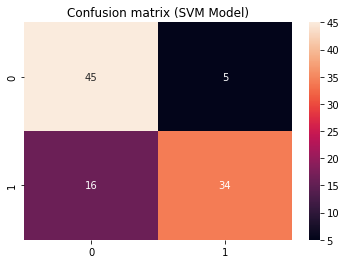

In [24]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.7900
Precision: 0.8718
Recall: 0.6800
F1 Score: 0.7640

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100



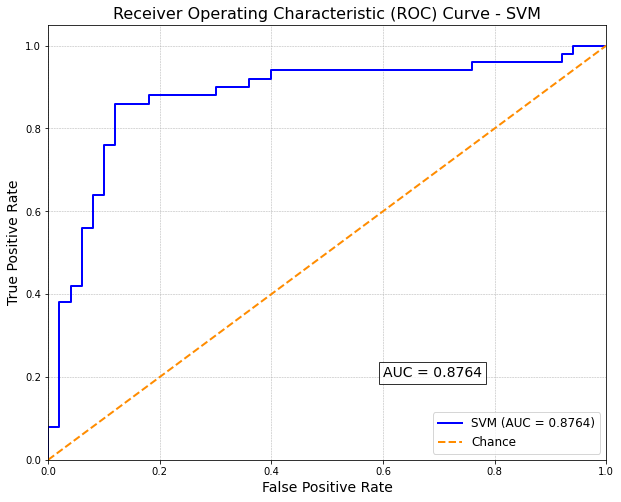

In [25]:
# Train the best SVM model
best_param_svm = study_svm.best_params
best_svm = SVC(**best_param_svm, random_state=123, probability=True)
best_svm.fit(x_train_, y_train)

# Predict on the test set
y_pred_svm = best_svm.predict(x_test_)
y_proba_svm = best_svm.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

## Xgboost

In [26]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


In [27]:
pos_weight = y_train.sum() / (len(y_train) - y_train.sum())
pos_weight

0.32620320855614976

In [28]:
# Creating and running our optimization
study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")

with parallel_backend('threading'):
    study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)

[I 2024-08-26 01:30:41,480] A new study created in memory with name: XGBoost
[I 2024-08-26 01:31:43,345] Trial 0 finished with value: 0.8761904729289278 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7814460116325461, 'colsample_bytree': 0.6198041867148261, 'reg_alpha': 0.0033462222732195254, 'reg_lambda': 0.014626318680101471}. Best is trial 0 with value: 0.8761904729289278.
[I 2024-08-26 01:31:45,735] Trial 2 finished with value: 0.8706214508382039 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.6140527873797752, 'colsample_bytree': 0.8182836488794463, 'reg_alpha': 8.588024652380771e-05, 'reg_lambda': 2.35521930340019}. Best is trial 0 with value: 0.8761904729289278.
[I 2024-08-26 01:32:00,668] Trial 7 finished with value: 0.8761170246478198 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.746001327057064, 'colsample_bytree': 0.5188589216457806, 'reg_alpha': 0.051481267386257606, 'reg_lambda': 0.007939620021473914}

In [29]:
# Evaluating our Optuna Trial
print("Best trial:", study_xgb.best_trial.number)
print("Best accuracy:", study_xgb.best_trial.value)
print("Best hyperparameters:", study_xgb.best_params)


Best trial: 17
Best accuracy: 0.8865457315867209
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8921366086209908, 'colsample_bytree': 0.9949041277044752, 'reg_alpha': 1.3591564325931434e-05, 'reg_lambda': 2.351665336453977e-05}


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



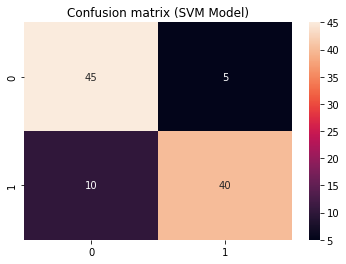

In [35]:
# Train the best XGBoost model
best_param_xgb = study_xgb.best_params
best_xgb = xgb.XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
best_xgb.fit(x_train_, y_train)
xgb=best_xgb.fit(x_train_, y_train)
y_pred_xgb = xgb.predict(x_test_)

display_results(y_test, y_pred_xgb, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8500
Precision: 0.8889
Recall: 0.8000
F1 Score: 0.8421

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



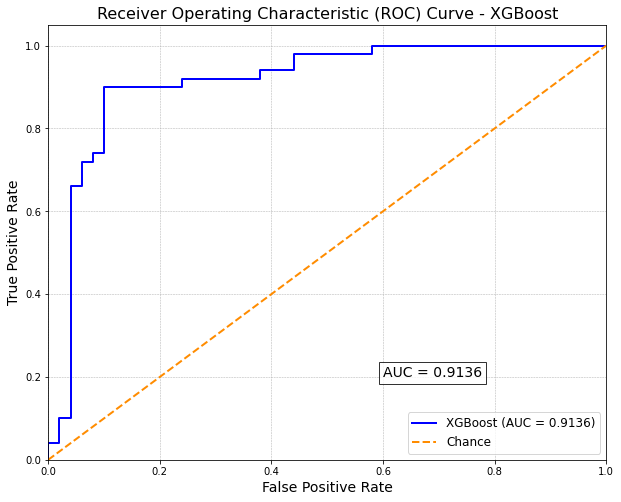

In [31]:
# Predict on the test set
y_pred_xgb = best_xgb.predict(x_test_)
y_proba_xgb = best_xgb.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_xgb:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# 5. Models Comparison

The ROC-Curve plot provides us with a clear view to choose the best model, as it is evident that the decision tree model has the largest area under the curve. Therefore, based on the ROC , the decision tree model is selected as the best model.

In [55]:


# Create a dictionary to store the metrics for each model
metrics_summary = {
    "Model": ["KNN", "SVM", "LR", "DecT", "XGB"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_lr, accuracy_dect, accuracy_xgb],
    "Recall": [recall_knn, recall_svm, recall_lr, recall_dect, recall_xgb],
    "Precision": [precision_knn, precision_svm, precision_lr, precision_dect, precision_xgb],
    "F1-Score": [f1_knn, f1_svm, f1_lr, f1_dect, f1_xgb],
    "AUC": [roc_auc_lr, roc_auc_svm, roc_auc_knn, roc_auc_dect, roc_auc_xgb]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,KNN,0.76,0.62,0.861111,0.720930,0.7896
1,SVM,0.79,0.68,0.871795,0.764045,0.8764
2,LR,0.50,0.00,0.000000,0.000000,0.8658
3,DecT,0.77,0.66,0.846154,0.741573,0.7632
4,XGB,0.85,0.80,0.888889,0.842105,0.9136


In [56]:
metrics_df.to_excel('result/40.xlsx', index=False)

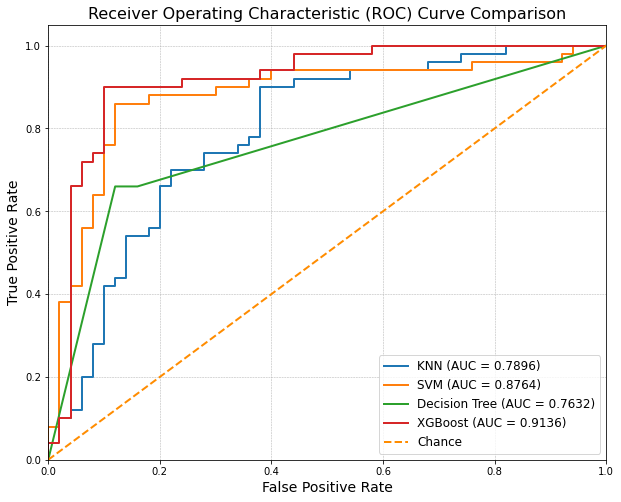

In [49]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for KNN
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'KNN (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Plot ROC curve for Logistic Regression
#plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Decision Tree
plt.plot(fpr_dect, tpr_dect, lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()
